# Meta-analytic functional decoding

## Continuous decoding

In this notebook, we applied meta-analytic functional decoding using the [NiMARE](https://nimare.readthedocs.io/en/stable/decoding.html). 

Specifically, we applied a continuous, correlation-based decoding approach to unthresholded meta-analytic statistical maps, assessing their similarity to term-based meta-analytic maps derived from large-scale databases such as Neurosynth.

In [5]:
# Import necessary modules
import os
import sys
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn import image, plotting, datasets
from nilearn.maskers import NiftiSpheresMasker

import nimare
from nimare.dataset import Dataset
from nimare.decode import discrete, continuous
from nimare.stats import pearson
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nilearn.masking import _unmask_3d

from wordcloud import WordCloud

# print the current working directory
# print(os.getcwd())

In [3]:
# get neurosynth data
databases = nimare.extract.fetch_neurosynth(data_dir='../1_Data/AnalysisData')[0]

# convert to NiMARE dataset (Note: This can take a while!)
ds = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=databases['coordinates'],
    metadata_file=databases['metadata'],
    annotations_files=databases['features']
    )

INFO:nimare.extract.utils:Dataset created in ../1_Data/AnalysisData/neurosynth
INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('data-neurosynth', 'version-7')]


In [6]:
# fetch cognitive atlas terms

base_url = "https://www.cognitiveatlas.org/api/v-alpha"

# Fetch concepts and tasks from Cognitive Atlas API
concepts = requests.get(f"{base_url}/concept?format=json").json()
tasks = requests.get(f"{base_url}/task?format=json").json()

# Collect term names (lowercase for matching)
cognitive_terms = [c["name"].lower() for c in concepts] + \
                  [t["name"].lower() for t in tasks]

print(f"Fetched {len(cognitive_terms)} cognitive terms from Cognitive Atlas.")


Fetched 1774 cognitive terms from Cognitive Atlas.


In [ ]:
# filter nimare annotations
# keep study identifier plus cognitive atlas–matched terms
terms_to_keep = ["id"] + [
    col for col in ds.annotations.columns
    if col.split("__")[-1].lower() in cognitive_terms
]

ds.annotations = ds.annotations[terms_to_keep]

print(f"Remaining features after filtering: {len(ds.annotations.columns) - 1}")

Remaining features after filtering: 133


In [ ]:
# ensure required identifier columns exist

if "study_id" not in ds.annotations.columns:
    ds.annotations["study_id"] = ds.annotations["id"]

if "contrast_id" not in ds.annotations.columns:
    ds.annotations["contrast_id"] = ds.annotations["id"]


In [ ]:
# Continuous functional decoding
# zmap_path = ("../3_Output/1_ALE/hypoactivation_z.nii.gz")
# zmap_path = ("../3_Output/2_Contrast/Control_all_minus_patient_z.nii.gz")
# zmap_path = ("../3_Output/1_ALE/hyperactivation_z.nii.gz")

zmap_path = ("../3_Output/1_ALE/heper_and_hypo_z.nii.gz")
print(f"Running continuous decoding for:\n{zmap_path}")

In [ ]:
# load target image
target_img = nib.load(zmap_path)

In [ ]:
# define decoder parameters
decoder = continuous.CorrelationDecoder(
    frequency_threshold=0.001
)

decoder.fit(ds)
results = decoder.transform(target_img)
results.head()

# results.to_csv("../3_Output/4_Decoding/contrast.csv", index=True)
# results.to_csv("../3_Output/4_Decoding/hyperactivation.csv", index=True)
# results.to_csv("../3_Output/4_Decoding/hypoactivation.csv", index=True)

results.to_csv("../3_Output/4_Decoding/heper_and_hypo.csv", index=True)

# Visualization: Word Cloud of Key Terms

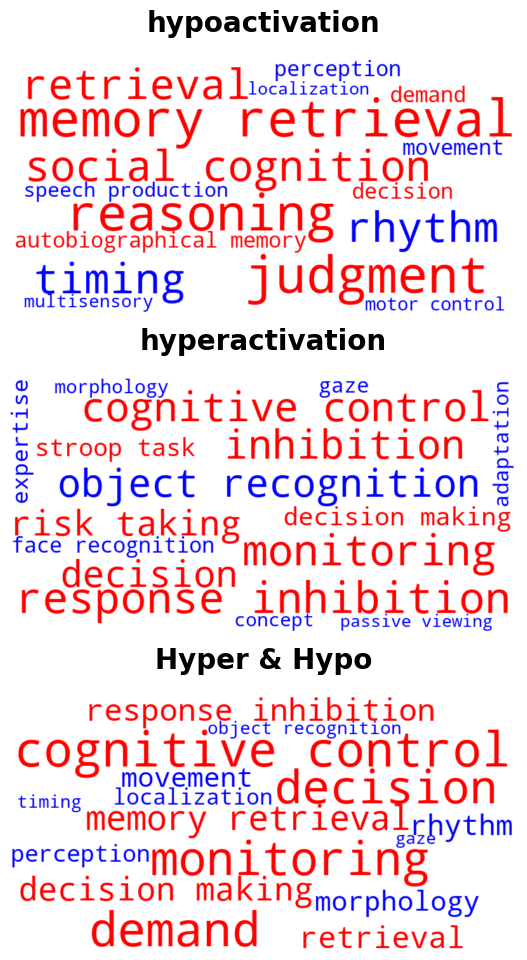

In [8]:
# Single analyses

files = [
    '../3_Output/4_Decoding/hypoactivation.csv', 
    '../3_Output/4_Decoding/hyperactivation.csv', 
    '../3_Output/4_Decoding/heper_and_hypo.csv'
]

titles = [
    'hypoactivation',
    'hyperactivation',
    'Hyper & Hypo'
]

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes = axes.flatten()

for i, file_name in enumerate(files):
    df = pd.read_csv(file_name)
    df['feature'] = df['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)
    
    # 1. 筛选正相关前 8 和负相关前 8
    pos_top8 = df.sort_values(by='r', ascending=False).head(8)
    neg_top8 = df.sort_values(by='r', ascending=True).head(8)
    
    # 合并数据
    combined_df = pd.concat([pos_top8, neg_top8])
    
    # 2. 构建字号权重（必须为正数）和颜色映射字典
    # 使用绝对值来决定大小
    word_freq = dict(zip(combined_df['feature'], combined_df['r'].abs()))
    # 记录原始正负号用于着色
    word_color_map = dict(zip(combined_df['feature'], combined_df['r']))
    
    # 3. 定义颜色函数
    def color_func(word, *args, **kwargs):
        if word_color_map.get(word, 0) > 0:
            return "red"     # 正相关为红
        else:
            return "blue"    # 负相关为蓝

    # 4. 生成词云
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=16,         # 8正 + 8负
        color_func=color_func,
        prefer_horizontal=0.8,
        random_state=42,
        relative_scaling=0.5
    ).generate_from_frequencies(word_freq)
    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(titles[i], fontsize=20, fontweight='bold', pad=20)
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

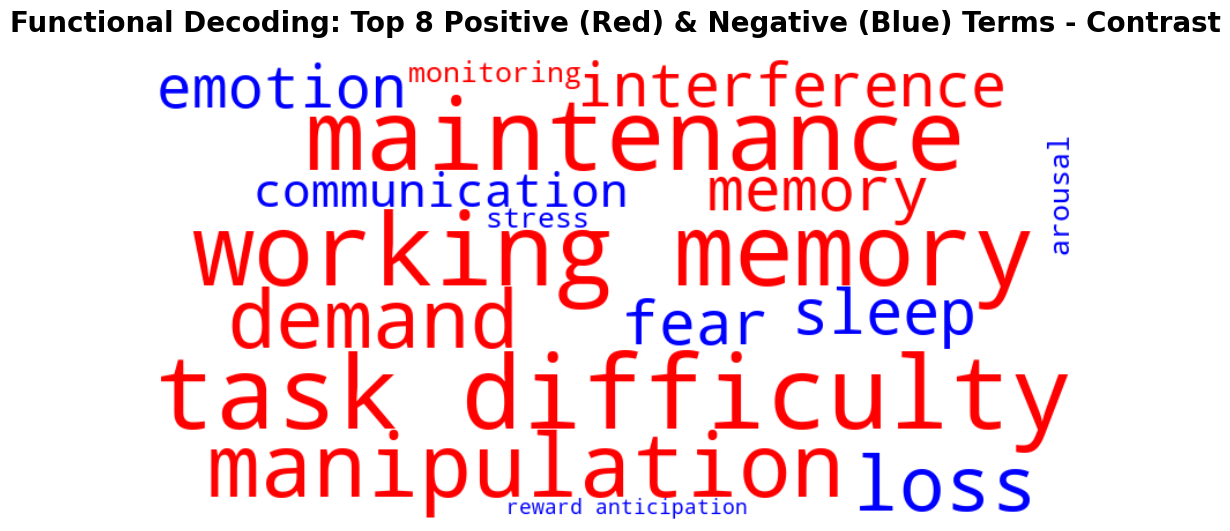

In [ ]:
# Contrast analysis

file_name = '../3_Output/4_Decoding/contrast.csv'
title = 'Contrast'

# 读取数据
df = pd.read_csv(file_name)
df['feature'] = df['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)

# 筛选正相关前 8 和负相关前 8
pos_top8 = df.sort_values(by='r', ascending=False).head(8)
neg_top8 = df.sort_values(by='r', ascending=True).head(8)

# 合并数据
combined_df = pd.concat([pos_top8, neg_top8])

# 构建词频和颜色映射
word_freq = dict(zip(combined_df['feature'], combined_df['r'].abs()))
word_color_map = dict(zip(combined_df['feature'], combined_df['r']))

# 定义颜色函数
def color_func(word, *args, **kwargs):
    return "blue" if word_color_map.get(word, 0) > 0 else "red"

# 生成词云
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=16,
    color_func=color_func,
    prefer_horizontal=0.8,
    random_state=42,
    relative_scaling=0.5
).generate_from_frequencies(word_freq)

# 绘图
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()